# Аугментация. Оценка необходимости применения. CIFAR-100

1. Обучение CNN на CIFAR-100.
2. Обучение CNN на CIFAR-100 через дообучение ImageNet Resnet-50.
3. Обучение CNN на CIFAR-100 через дообучение ImageNet Resnet-50 с аугментацией данных.
4. Сравнение результатов обучения на эквивалентном числе эпох.

In [126]:
import torch
import numpy as np
import torch.nn.functional as F
import torchvision

from torch import nn
from torch import optim

import matplotlib.pyplot as plt
# %pylab inline

from PIL import Image
from torchvision import transforms, datasets
from tqdm import tqdm

from scipy import misc

from sklearn.model_selection import train_test_split

In [72]:
layer = torch.nn.Conv2d(
    in_channels=2,
    out_channels=3,
    kernel_size=2,
    stride=2,
    padding=2,
    padding_mode='zeros',
    dilation=2, # 2
    bias=True
)

In [73]:
layer = torch.nn.MaxPool2d(
    kernel_size=4,
    stride=1,
    #padding=0,
)

In [74]:
dataset = datasets.CIFAR100(root='data/', train=True, download=True)

Files already downloaded and verified


In [75]:
class MyOwnCifar(torch.utils.data.Dataset):

    def __init__(self, init_dataset, transform=None):
        self._base_dataset = init_dataset
        self.transform = transform

    def __len__(self):
        return len(self._base_dataset)

    def __getitem__(self, idx):
        img = self._base_dataset[idx][0]
        if self.transform is not None:
            img = self.transform(img)
        return img, self._base_dataset[idx][1]

In [76]:
trans_actions = transforms.Compose([transforms.Resize(44),
                                    transforms.RandomCrop(32, padding=4),
                                    transforms.ToTensor()])


def train_valid_split(data):
    data_train, data_test = train_test_split(data, test_size=0.05, random_state=13)
    return data_train, data_test

train_dataset, valid_dataset = train_valid_split(dataset)

train_dataset = MyOwnCifar(train_dataset, trans_actions)
valid_dataset = MyOwnCifar(valid_dataset, transforms.ToTensor())

In [77]:
train_loader = torch.utils.data.DataLoader(train_dataset,
                          batch_size=128,
                          shuffle=True,
                          num_workers=2)
valid_loader = torch.utils.data.DataLoader(valid_dataset,
                          batch_size=128,
                          shuffle=False,
                          num_workers=1)

In [78]:
classes = dataset.classes
print(classes)

['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree',

torch.Size([128, 3, 32, 32])
pickup_truck


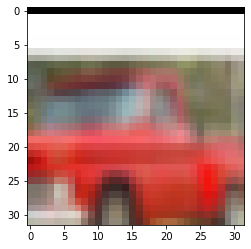

In [79]:
import matplotlib.pyplot as plt


for img, lbl in train_loader:
    print(img.shape)
    print(classes[lbl[0]])
    plt.imshow(img[0].permute(1, 2, 0))
    break

In [80]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [81]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.dp_one = nn.Dropout(0.2)
        self.dp_two = nn.Dropout(0.2)

        self.bn_one = torch.nn.BatchNorm2d(3)
        self.conv_one = torch.nn.Conv2d(3, 30, 3)#30
        self.bn_two = torch.nn.BatchNorm2d(30)
        self.conv_two = torch.nn.Conv2d(30, 60, 3)#
        self.bn_three = torch.nn.BatchNorm2d(60)
        self.conv_three = torch.nn.Conv2d(60, 120, 3)
        self.bn_four = torch.nn.BatchNorm2d(120)
        self.fc1 = torch.nn.Linear(480, 300)
        self.fc2 = torch.nn.Linear(300, 200)
        self.out = torch.nn.Linear(200, 100)

    def forward(self, x):
        x = self.bn_one(x)# 32x32x3
        x = self.conv_one(x)#30x30x30
        x = F.relu(x)
        x = F.max_pool2d(x, 2)#30x15x15

        x = self.bn_two(x)
        x = self.conv_two(x)#60 x 13x13
        x = F.relu(x)
        x = F.max_pool2d(x, 2)#60 x 6 x 6

        x = self.bn_three(x)
        x = self.conv_three(x)#120 x 4 x 4
        x = F.leaky_relu(x, 0.1)
        x = F.max_pool2d(x, 2) #120 x 2 x 2

        x = self.bn_four(x)
        x = x.view(x.size(0), -1) # 120 x 4
        x = self.dp_one(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dp_two(x)
        x = self.fc2(x)
        x = F.relu(x)
        return self.out(x)

net = Net().to(device)
print(net)

Net(
  (dp_one): Dropout(p=0.2, inplace=False)
  (dp_two): Dropout(p=0.2, inplace=False)
  (bn_one): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_one): Conv2d(3, 30, kernel_size=(3, 3), stride=(1, 1))
  (bn_two): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_two): Conv2d(30, 60, kernel_size=(3, 3), stride=(1, 1))
  (bn_three): BatchNorm2d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_three): Conv2d(60, 120, kernel_size=(3, 3), stride=(1, 1))
  (bn_four): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=480, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=200, bias=True)
  (out): Linear(in_features=200, out_features=100, bias=True)
)


In [82]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [83]:
!pip install torchsummary

/bin/bash: /home/ekaterina/anaconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [84]:
from torchsummary import summary

summary(net.to(device), input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm2d-1            [-1, 3, 32, 32]               6
            Conv2d-2           [-1, 30, 30, 30]             840
       BatchNorm2d-3           [-1, 30, 15, 15]              60
            Conv2d-4           [-1, 60, 13, 13]          16,260
       BatchNorm2d-5             [-1, 60, 6, 6]             120
            Conv2d-6            [-1, 120, 4, 4]          64,920
       BatchNorm2d-7            [-1, 120, 2, 2]             240
           Dropout-8                  [-1, 480]               0
            Linear-9                  [-1, 300]         144,300
          Dropout-10                  [-1, 300]               0
           Linear-11                  [-1, 200]          60,200
           Linear-12                  [-1, 100]          20,100
Total params: 307,046
Trainable params: 307,046
Non-trainable params: 0
-------------------------------

In [85]:
num_epochs = 10
net.train()

for epoch in range(num_epochs):
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        # обнуляем градиент
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # выводим статистику о процессе обучения
        running_loss += loss.item()
        running_items += len(labels)
        running_right += (labels == torch.max(outputs, 1)[1]).sum()

        # выводим статистику о процессе обучения
        if i % 300 == 0:    # печатаем каждые 300 mini-batches
            net.eval()

            print(f'Epoch [{epoch + 1}/{num_epochs}]. ' \
                  f'Step [{i + 1}/{len(train_loader)}]. ' \
                  f'Loss: {running_loss / running_items:.3f}. ' \
                  f'Acc: {running_right / running_items:.3f}', end='. ')
            running_loss, running_items, running_right = 0.0, 0.0, 0.0

            test_running_right, test_running_total = 0.0, 0.0
            for i, data in enumerate(valid_loader):

                test_outputs = net(data[0].to(device))
                test_running_total += len(data[1])
                test_running_right += (data[1].to(device) == torch.max(test_outputs, 1)[1]).sum()

            print(f'Test acc: {test_running_right / test_running_total:.3f}')

        net.train()

print('Training is finished!')

Epoch [1/10]. Step [1/372]. Loss: 0.036. Acc: 0.000. Test acc: 0.012
Epoch [1/10]. Step [301/372]. Loss: 0.033. Acc: 0.044. Test acc: 0.068
Epoch [2/10]. Step [1/372]. Loss: 0.032. Acc: 0.062. Test acc: 0.082
Epoch [2/10]. Step [301/372]. Loss: 0.031. Acc: 0.071. Test acc: 0.096
Epoch [3/10]. Step [1/372]. Loss: 0.030. Acc: 0.086. Test acc: 0.108
Epoch [3/10]. Step [301/372]. Loss: 0.031. Acc: 0.089. Test acc: 0.112
Epoch [4/10]. Step [1/372]. Loss: 0.030. Acc: 0.086. Test acc: 0.105
Epoch [4/10]. Step [301/372]. Loss: 0.030. Acc: 0.097. Test acc: 0.114
Epoch [5/10]. Step [1/372]. Loss: 0.029. Acc: 0.133. Test acc: 0.096
Epoch [5/10]. Step [301/372]. Loss: 0.030. Acc: 0.106. Test acc: 0.108
Epoch [6/10]. Step [1/372]. Loss: 0.030. Acc: 0.102. Test acc: 0.142
Epoch [6/10]. Step [301/372]. Loss: 0.029. Acc: 0.115. Test acc: 0.124
Epoch [7/10]. Step [1/372]. Loss: 0.029. Acc: 0.102. Test acc: 0.113
Epoch [7/10]. Step [301/372]. Loss: 0.029. Acc: 0.124. Test acc: 0.134
Epoch [8/10]. Step [

## Предобученные сети

In [86]:
from torchvision import models

resnet18 = models.resnet18(  pretrained=True)
print(resnet18)

/home/ekaterina/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ekaterina/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/ekaterina/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:05<00:00, 9.04MB/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [87]:
from torchsummary import summary
summary(resnet18.to(device), input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

Замораживаем претренированную модель:

In [88]:
for param in list(resnet18.parameters())[:]:
    param.requires_grad = False

Можем заменить свой слой для работы на выходе(у нас их 100):

In [89]:
resnet18.fc = nn.Linear(512, 100)

summary(resnet18.to(device), input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

In [90]:
resnet18 = resnet18.to(device)

Данные:

In [91]:
train_actions = transforms.Compose([transforms.Resize(256),
                                    transforms.RandomCrop(224, padding=4),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                         std=[0.229, 0.224, 0.225])])
valid_transforms = transforms.Compose([transforms.Resize(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                            std=[0.229, 0.224, 0.225])])


train_dataset, valid_dataset = train_valid_split(dataset)

train_dataset = MyOwnCifar(train_dataset, train_actions)
valid_dataset = MyOwnCifar(valid_dataset, valid_transforms)

In [92]:
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                           batch_size=128,
                                           shuffle=False,
                                           num_workers=1)

Нужно собрать список параметров для адаптации

In [93]:
params_to_update = []
for name, param in resnet18.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)


optimizer = torch.optim.Adam(params_to_update, lr=0.001)
criterion = nn.CrossEntropyLoss()

Учим:

In [94]:
num_epochs = 10
resnet18.train()

for epoch in range(num_epochs):
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    for i, data in enumerate(train_loader):
        inputs, labels = data[0].to(device), data[1].to(device)

        # обнуляем градиент
        optimizer.zero_grad()

        outputs = resnet18(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # выводим статистику о процессе обучения
        running_loss += loss.item()
        running_items += len(labels)
        running_right += (labels == torch.max(outputs, 1)[1]).sum()

        # выводим статистику о процессе обучения
        if i % 300 == 0:    # печатаем каждые 300 mini-batches
            resnet18.eval()

            print(f'Epoch [{epoch + 1}/{num_epochs}]. ' \
                  f'Step [{i + 1}/{len(train_loader)}]. ' \
                  f'Loss: {running_loss / running_items:.3f}. ' \
                  f'Acc: {running_right / running_items:.3f}', end='. ')
            running_loss, running_items, running_right = 0.0, 0.0, 0.0

            test_running_right, test_running_total = 0.0, 0.0
            for i, data in enumerate(valid_loader):

                test_outputs = resnet18(data[0].to(device))
                test_running_total += len(data[1])
                test_running_right += (data[1].to(device) == torch.max(test_outputs, 1)[1]).sum()

            print(f'Test acc: {test_running_right / test_running_total:.3f}')

        resnet18.train()

print('Training is finished!')

Epoch [1/10]. Step [1/372]. Loss: 0.038. Acc: 0.000. Test acc: 0.012
Epoch [1/10]. Step [301/372]. Loss: 0.022. Acc: 0.348. Test acc: 0.496
Epoch [2/10]. Step [1/372]. Loss: 0.017. Acc: 0.422. Test acc: 0.499
Epoch [2/10]. Step [301/372]. Loss: 0.014. Acc: 0.519. Test acc: 0.539
Epoch [3/10]. Step [1/372]. Loss: 0.011. Acc: 0.625. Test acc: 0.548
Epoch [3/10]. Step [301/372]. Loss: 0.013. Acc: 0.550. Test acc: 0.560
Epoch [4/10]. Step [1/372]. Loss: 0.012. Acc: 0.594. Test acc: 0.563
Epoch [4/10]. Step [301/372]. Loss: 0.012. Acc: 0.566. Test acc: 0.572
Epoch [5/10]. Step [1/372]. Loss: 0.011. Acc: 0.633. Test acc: 0.569
Epoch [5/10]. Step [301/372]. Loss: 0.012. Acc: 0.575. Test acc: 0.570
Epoch [6/10]. Step [1/372]. Loss: 0.011. Acc: 0.656. Test acc: 0.588
Epoch [6/10]. Step [301/372]. Loss: 0.012. Acc: 0.583. Test acc: 0.588
Epoch [7/10]. Step [1/372]. Loss: 0.012. Acc: 0.555. Test acc: 0.563
Epoch [7/10]. Step [301/372]. Loss: 0.011. Acc: 0.590. Test acc: 0.578
Epoch [8/10]. Step [

In [95]:
resnet18.eval()
for data in valid_loader:
  test_outputs = resnet18(data[0].to(device))
  label = data[1].to(device)
  predict = torch.max(test_outputs, 1)[1]
  break
print(predict)
print(label)
print((predict == label).sum()/predict.shape[0])


tensor([88, 97,  8, 90, 29, 55, 65, 81, 64,  0, 72, 37, 87, 85, 76, 44, 49, 77,
        93, 15, 30, 21, 46, 60, 13, 87, 89, 54, 36,  7, 64, 94, 69, 95, 67, 19,
        22, 13, 14, 81, 44, 72, 75, 22, 53, 79, 13, 55, 85, 78,  1, 19, 90, 52,
        74, 39,  6, 17, 68, 52, 76, 66, 41, 52, 53,  0, 40, 24, 97, 86, 43, 89,
        58, 49, 48, 48,  5, 70, 48, 38, 57, 42, 26, 21, 24, 84, 85, 24, 27, 67,
        90, 57, 49, 26, 86, 86, 10, 71, 25, 38, 63, 17, 74, 53, 53, 83, 29, 95,
        83, 52,  3, 72, 14, 91, 69, 77, 82, 15, 61,  4, 28, 92, 19,  5, 49, 79,
        38, 41])
tensor([88, 97,  8, 90, 31, 72, 65, 87, 64,  0,  3, 12, 87, 19, 76, 44, 49, 77,
        93, 15, 30, 21, 46, 60, 90, 87, 89, 54, 36, 79, 65, 94, 69, 49, 91, 19,
        22, 13, 14, 37, 44, 72, 50, 10, 53, 79, 89, 55, 15, 78,  1, 98, 13, 59,
         4, 39,  6, 17, 33, 52, 76, 97, 41, 47, 53, 10, 85, 98, 74, 86, 43, 41,
        58, 49, 48, 48, 25, 70, 48, 38, 54, 66, 61, 46, 24, 13, 90,  7, 27, 93,
        68, 55, 49, 55,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


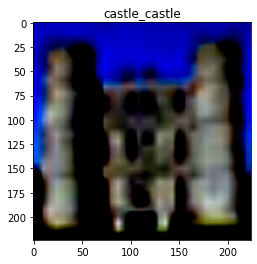

In [102]:
N = 101
plt.imshow(data[0][N,:,:,:].permute(1, 2, 0)/data[0][N,:,:,:].max())
plt.title(classes[label[N]]+'_'+classes[predict[N]])
plt.show()

## С аугментацией данных

In [274]:
#!pip install albumentations

In [299]:
train_dataset, valid_dataset = train_valid_split(dataset)

In [276]:
class MyOwnCifar(torch.utils.data.Dataset):

    def __init__(self, init_dataset, transform=None):
        self._base_dataset = init_dataset
        self.transform = transform

    def __len__(self):
        return len(self._base_dataset)

    def __getitem__(self, idx):
        img = self._base_dataset[idx][0]
        if self.transform is not None:
            img = self.transform(img)
        return img, self._base_dataset[idx][1]

In [277]:
train_actions = transforms.Compose([transforms.Resize(256),
                                    transforms.RandomCrop(224, padding=4),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                         std=[0.229, 0.224, 0.225])])
valid_transforms = transforms.Compose([transforms.Resize(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                            std=[0.229, 0.224, 0.225])])


train_dataset, valid_dataset = train_valid_split(dataset)

In [356]:
def aug_data(data):
    alb_transform = alb.Compose(
    [
        alb.Resize(height=32, width=32),
        alb.RandomCrop(height=30, width=30),
        alb.HorizontalFlip(p=0.5),
        alb.SmallestMaxSize(max_size=28),
        alb.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=1),
        alb.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        alb.RandomBrightnessContrast(p=0.5),
        alb.OneOf([
            alb.MotionBlur(p=1),
            alb.OpticalDistortion(p=1),
            alb.GaussNoise(p=1)
        ], p=1),
        alb.Normalize(mean=(0.485, 0.456, 0.406),
                      std=(0.229, 0.224, 0.225))
    ])
    data_aug = []
    for el in data:
        alb_img = alb_transform(image=np.array(el[0]))['image']
        alb_img = Image.fromarray(np.uint8(alb_img)*255)
        label = el[1]
        data_aug.append((alb_img, label))
    return data_aug      
    

In [357]:
# Добавим измененные с помощью аугментации изображения в тренировочный датасет.
#Чтобы данных не было слишком много, добавим лишь по одному экземпляру измененного изображения каждой картинки
train_dataset_alb = aug_data(train_dataset) # Измененный тренировочный набор

In [359]:
train_dataset = MyOwnCifar(train_dataset+train_dataset_alb, train_actions)

valid_dataset = MyOwnCifar(valid_dataset, valid_transforms)

train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                           batch_size=128,
                                           shuffle=False,
                                           num_workers=1)

In [360]:
num_epochs = 10
resnet18.train()

for epoch in range(num_epochs):
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    for i, data in enumerate(train_loader):
        inputs, labels = data[0].to(device), data[1].to(device)

        # обнуляем градиент
        optimizer.zero_grad()

        outputs = resnet18(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # выводим статистику о процессе обучения
        running_loss += loss.item()
        running_items += len(labels)
        running_right += (labels == torch.max(outputs, 1)[1]).sum()

        # выводим статистику о процессе обучения
        if i % 300 == 0:    # печатаем каждые 300 mini-batches
            resnet18.eval()

            print(f'Epoch [{epoch + 1}/{num_epochs}]. ' \
                  f'Step [{i + 1}/{len(train_loader)}]. ' \
                  f'Loss: {running_loss / running_items:.3f}. ' \
                  f'Acc: {running_right / running_items:.3f}', end='. ')
            running_loss, running_items, running_right = 0.0, 0.0, 0.0

            test_running_right, test_running_total = 0.0, 0.0
            for i, data in enumerate(valid_loader):

                test_outputs = resnet18(data[0].to(device))
                test_running_total += len(data[1])
                test_running_right += (data[1].to(device) == torch.max(test_outputs, 1)[1]).sum()

            print(f'Test acc: {test_running_right / test_running_total:.3f}')

        resnet18.train()

print('Training is finished!')

Epoch [1/10]. Step [1/743]. Loss: 0.030. Acc: 0.211. Test acc: 0.584
Epoch [1/10]. Step [301/743]. Loss: 0.027. Acc: 0.265. Test acc: 0.504
Epoch [1/10]. Step [601/743]. Loss: 0.025. Acc: 0.288. Test acc: 0.510
Epoch [2/10]. Step [1/743]. Loss: 0.023. Acc: 0.320. Test acc: 0.518
Epoch [2/10]. Step [301/743]. Loss: 0.024. Acc: 0.305. Test acc: 0.508
Epoch [2/10]. Step [601/743]. Loss: 0.024. Acc: 0.300. Test acc: 0.512
Epoch [3/10]. Step [1/743]. Loss: 0.022. Acc: 0.359. Test acc: 0.506
Epoch [3/10]. Step [301/743]. Loss: 0.023. Acc: 0.313. Test acc: 0.515
Epoch [3/10]. Step [601/743]. Loss: 0.023. Acc: 0.310. Test acc: 0.520
Epoch [4/10]. Step [1/743]. Loss: 0.022. Acc: 0.375. Test acc: 0.524
Epoch [4/10]. Step [301/743]. Loss: 0.023. Acc: 0.315. Test acc: 0.529
Epoch [4/10]. Step [601/743]. Loss: 0.023. Acc: 0.319. Test acc: 0.524
Epoch [5/10]. Step [1/743]. Loss: 0.021. Acc: 0.305. Test acc: 0.526
Epoch [5/10]. Step [301/743]. Loss: 0.023. Acc: 0.319. Test acc: 0.511


KeyboardInterrupt: 

Вывод: Наша сверточная сеть при обучении на 10 эпохах дала результат на cifar100 accuracy 0.149, предобученная сеть resnet18 после дообучения на наших данных дала результат accuracy 0.592, после проведения аугментации датасет увеличился вдвое (добавили по экземпляру каждого изображения в измененном виде), сеть обучается слишком долго, при этом по оценке 5 эпох обучения, без аугментации resnet18 с нашими входными данными и выходным слоем 100 классов работает лучше, чем с аугментацией. Необходим дополнительный анализ для оценки эффективности проведения аугментации.